In [1]:
import os, glob, warnings, random, pathlib
from datetime import timedelta
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils import clip_grad_norm_

import os, glob, warnings, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Model

In [2]:


warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
torch.manual_seed(0); np.random.seed(0)

DATA_DIR = r"Coins Data"
VAL_FRAC = 0.20
SEQ_LEN = 60
BATCH_SIZE = 256
N_EPOCHS = 5
LR = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
alpha = 0.2

Using device: cuda


In [3]:
def log_transform(y):
    return np.sign(y) * np.log1p(np.abs(y))

def log_inverse(y):
    return np.sign(y) * (np.expm1(np.abs(y)))

all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
n_val_files = max(1, int(len(all_files) * VAL_FRAC))
train_files = all_files[:-n_val_files]
val_files = all_files[-n_val_files:]

def load_concat(files):
    return pd.concat((pd.read_csv(fp) for fp in files), ignore_index=True)

train_df = load_concat(train_files)
val_df = load_concat(val_files)


In [4]:
def preprocess(df):
    if df["timestamp"].max() < 1e12:
        df["timestamp"] *= 1000
    df["dt"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
    df["pump_time"] = pd.to_datetime(df["pump_time"], utc=True)

    df["log_close"] = np.log(df["close"].replace(0, np.nan)).ffill()
    df["log_ret"] = df["log_close"].diff().fillna(0)
    df["return_diff"] = df["log_ret"].diff().fillna(0)
    df["volatility"] = df["log_ret"].rolling(10).std().bfill()
    df["momentum"] = df["close"].diff(5).fillna(0)
    df["volume_std"] = df["volume"].rolling(10).std().bfill()
    df["volume_ratio"] = df["volume"] / df["volume"].rolling(10).mean().bfill()
    df["norm_close"] = df["close"] / df["close"].rolling(30).mean().bfill()
    df["norm_volume"] = df["volume"] / df["volume"].rolling(30).mean().bfill()
    df["PCT_change"] = df["close"] / df["open"] - 1

    feature_cols = ["PCT_change", "log_ret", "return_diff", "volatility", "momentum",
                    "volume_std", "volume_ratio", "norm_close", "norm_volume"]
    df[feature_cols] = df[feature_cols].fillna(0)

    ahead_min = (df["pump_time"] - df["dt"]).dt.total_seconds() / 60.0
    
    window_minutes = [10, 30, 60, 3*60, 12*60]
    for w in window_minutes:
        df[f'y_{w}m'] = ((ahead_min >= 0) & (ahead_min <= w)).astype(int)
    label_cols = [f'y_{w}m' for w in window_minutes]
    
    #df["y"] = log_transform(ahead_min)
    return df, feature_cols, label_cols

train_df, feature_cols, label_cols = preprocess(train_df)
val_df, _,_ = preprocess(val_df)

# Scale features ? might need to be removed

train_df.head(5)

,timestamp,open,high,low,close,volume,symbol,pump_time,is_pump,is_pump_window,...,volume_std,volume_ratio,norm_close,norm_volume,PCT_change,y_10m,y_30m,y_60m,y_180m,y_720m
0,1561309200000,0.000013,0.000013,0.000013,0.000013,0.0,ADX,2019-07-05 17:00:00+00:00,False,False,...,401.074335,0.000000,0.999975,0.000000,0.000000,0,0,0,0,0
1,1561309260000,0.000013,0.000013,0.000013,0.000013,0.0,ADX,2019-07-05 17:00:00+00:00,False,False,...,401.074335,0.000000,0.999975,0.000000,0.000000,0,0,0,0,0
2,1561309320000,0.000013,0.000013,0.000013,0.000013,0.0,ADX,2019-07-05 17:00:00+00:00,False,False,...,401.074335,0.000000,0.999975,0.000000,0.000000,0,0,0,0,0
3,1561309380000,0.000013,0.000013,0.000013,0.000013,0.0,ADX,2019-07-05 17:00:00+00:00,False,False,...,401.074335,0.000000,0.999975,0.000000,0.000000,0,0,0,0,0
4,1561309440000,0.000013,0.000013,0.000013,0.000013,790.0,ADX,2019-07-05 17:00:00+00:00,False,False,...,401.074335,3.175241,0.999975,0.380228,0.001484,0,0,0,0,0


In [5]:

def make_windows(frame):
    X, y = [], []
    arr = frame[feature_cols].values.astype("float32")
    lab = frame[label_cols].values.astype("float32")
    for i in range(SEQ_LEN-1, len(frame)):
        X.append(arr[i-SEQ_LEN+1:i+1])
        y.append(lab[i])
    return np.stack(X), np.array(y)

X_tr, y_tr = make_windows(train_df)
X_va, y_va = make_windows(val_df)

In [6]:

class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

tr_loader = DataLoader(SeqDS(X_tr, y_tr), BATCH_SIZE, shuffle=True, drop_last=True)
va_loader = DataLoader(SeqDS(X_va, y_va), BATCH_SIZE, shuffle=False)

class EnhancedLSTM(nn.Module):
    def __init__(self, d_feat, hidden=128, num_layers=3):
        super().__init__()
        self.rnn = nn.LSTM(d_feat, hidden, num_layers=num_layers, batch_first=True, dropout=0.3)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden, hidden // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden // 2, len(label_cols))  # Output for each label column
    def forward(self, x):
        _, (h_last, _) = self.rnn(x)
        out = self.dropout(h_last[-1])
        out = self.relu(self.fc1(out))
        return self.fc2(out).squeeze(-1)

model = EnhancedLSTM(len(feature_cols)).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
crit = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)


In [ ]:
from tqdm.auto import tqdm
train_losses = []
val_losses = []

for ep in range(1, N_EPOCHS + 1):
    model.train()
    epoch_train_loss = 0
    train_loader_tqdm = tqdm(tr_loader, desc=f"Epoch {ep:02d} [Train]", leave=False)
    for xb, yb in train_loader_tqdm:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)  # shape: (batch, num_windows)

        output = model(xb)  # shape: (batch, num_windows)

        loss = crit(output, yb.float())
        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_train_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(tr_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0
    preds, ys = [], []
    val_loader_tqdm = tqdm(va_loader, desc=f"Epoch {ep:02d} [Val]", leave=False)
    with torch.no_grad():
        for xb, yb in val_loader_tqdm:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            output = model(xb)

            loss = crit(output, yb.float())
            epoch_val_loss += loss.item()

            preds.append(torch.sigmoid(output).cpu())  # probabilities
            ys.append(yb.cpu())

            val_loader_tqdm.set_postfix(loss=loss.item())

    avg_val_loss = epoch_val_loss / len(va_loader)
    val_losses.append(avg_val_loss)

    preds = torch.cat(preds)  # (num_samples, num_windows)
    ys = torch.cat(ys)        # (num_samples, num_windows)

    print(f"Epoch {ep:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    for i, w in enumerate(window_hours):
        pred_bin = (preds[:, i] > 0.5).int()
        true_bin = ys[:, i].int()
        acc = (pred_bin == true_bin).float().mean().item()
        print(f"   Window {w}h | Val Accuracy: {acc:.4f}")

# Plotting losses
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Epoch 01 [Train]:   0%|          | 0/29417 [00:00<?, ?it/s]

In [ ]:
import torch
import os
from datetime import datetime

# -------------------------------------------------------------
# 1)  Where to save
# -------------------------------------------------------------
SAVE_DIR = "./checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
ckpt_path = os.path.join(SAVE_DIR, f"model_{timestamp}.pt")

# -------------------------------------------------------------
# 2)  What to save
#     – model weights
#     – fitted scaler (for inference)
#     – feature column order
# -------------------------------------------------------------
torch.save(
    {
        "model_state": model.state_dict(),   # trained LSTM weights
        "scaler": scaler,                    # StandardScaler instance
        "feature_cols": feature_cols         # list of feature names
    },
    ckpt_path
)

print(f"✓ Model checkpoint saved to {ckpt_path}")


✓ Model checkpoint saved to ./checkpoints\model_20250702_085103.pt


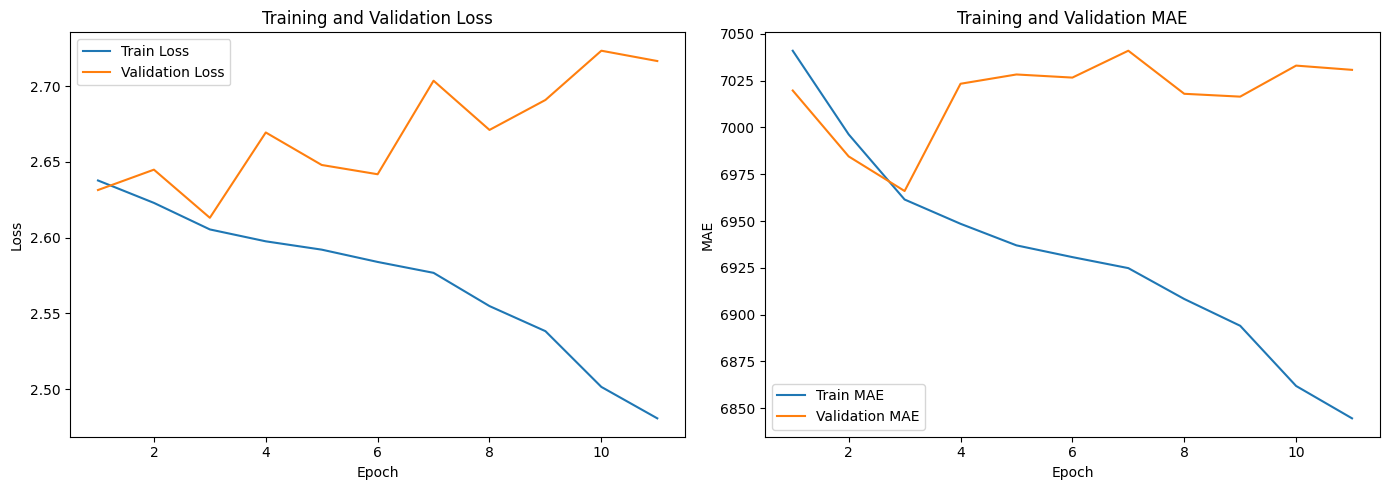

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_maes, label='Train MAE')
plt.plot(epochs, val_maes, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

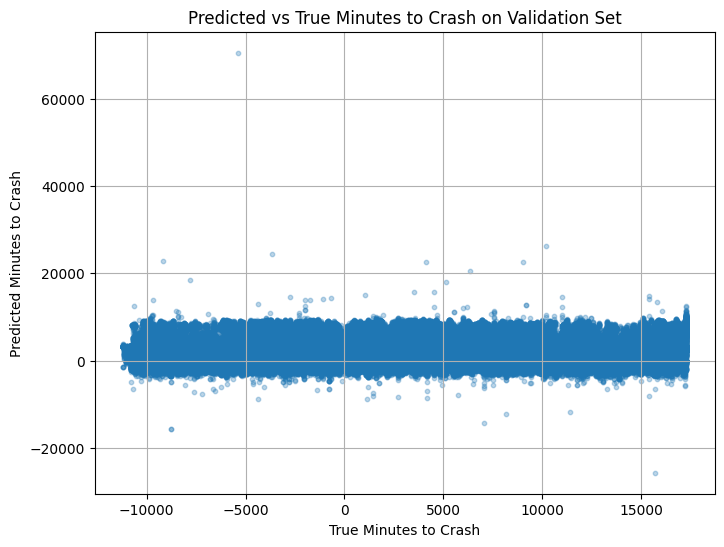

Spearman correlation: 0.030
Pearson correlation: 0.031


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# Gather validation predictions and labels
model.eval()
preds, ys = [], []
with torch.no_grad():
    for xb, yb in va_loader:
        preds.append(model(xb.to(DEVICE)).cpu())
        ys.append(yb)
preds = torch.cat(preds).numpy()
ys = torch.cat(ys).numpy()

# Inverse transform for interpretability
preds_inv = log_inverse(preds)
ys_inv = log_inverse(ys)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(ys_inv, preds_inv, alpha=0.3, s=10)
plt.xlabel("True Minutes to Crash")
plt.ylabel("Predicted Minutes to Crash")
plt.title("Predicted vs True Minutes to Crash on Validation Set")
plt.grid(True)
plt.show()

# Correlation diagnostics
spearman_corr, _ = spearmanr(ys_inv, preds_inv)
pearson_corr, _ = pearsonr(ys_inv, preds_inv)
print(f"Spearman correlation: {spearman_corr:.3f}")
print(f"Pearson correlation: {pearson_corr:.3f}")


In [ ]:
# ---------------------------------------------------------------------------
# Enrich every PnD CSV with the ORIGINAL feature columns
# and save to pnd_enriched / <same-name>.csv
# ---------------------------------------------------------------------------
import os, glob, numpy as np, pandas as pd
from pathlib import Path

IN_DIR  = r"C:\Users\michael\Desktop\memedenis\data"       # raw ±7-day files
OUT_DIR = r"C:\Users\michael\Desktop\memedenis\features"   # where enriched files go
Path(OUT_DIR).mkdir(exist_ok=True)

def add_original_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("timestamp").reset_index(drop=True)

    # -------- original 10 engineered columns -----------------------------
    df["log_return"]    = np.log(df["close"].replace(0, np.nan)).diff().fillna(0)
    df["return_diff"]   = df["log_return"].diff().fillna(0)
    df["volatility"]    = df["log_return"].rolling(10).std().bfill()
    df["momentum"]      = df["close"].diff(5).fillna(0)
    df["volume_std"]    = df["volume"].rolling(10).std().bfill()
    df["volume_ratio"]  = df["volume"] / df["volume"].rolling(10).mean().bfill()
    df["norm_close"]    = df["close"]  / df["close"].rolling(30).mean().bfill()
    df["norm_volume"]   = df["volume"] / df["volume"].rolling(30).mean().bfill()
    # keep the two raw columns that were also part of the feature set
    # (close, volume) already exist in the file

    return df

# -------- process each CSV ----------------------------------------------
for fp in glob.glob(os.path.join(IN_DIR, "*.csv")):
    df_in  = pd.read_csv(fp)
    df_out = add_original_features(df_in)

    out_path = os.path.join(OUT_DIR, os.path.basename(fp))
    df_out.to_csv(out_path, index=False)
    print(f"✓ saved {out_path}")


✓ saved C:\Users\michael\Desktop\memedenis\features\ADX_2019-07-26 17.59.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\ADX_2020-07-07 16.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\AMB_2019-01-01 14.30.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\APPC_2020-11-04 17.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\APPC_2020-11-18 18.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\APPC_2020-11-27 18.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\APPC_2020-12-07 16.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\APPC_2021-01-13 21.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\ARDR_2019-04-17 17.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\ARDR_2019-05-31 17.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\ARDR_2020-11-02 16.00.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\ARN_2018-04-10 16.30.csv
✓ saved C:\Users\michael\Desktop\memedenis\features\ARN_2020-04-07 1

In [ ]:
# ---------------------------------------------------------------------------
# LOAD a saved “original-LSTM” checkpoint
# and get it ready for inference
# ---------------------------------------------------------------------------
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ---- path to the checkpoint you saved after training ---------------------
CKPT_PATH = "./checkpoints/model_20250628_161708.pt"   # change if you renamed the file
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"

# ---- 1. define the SAME model architecture ------------------------------
class SimpleLSTM(torch.nn.Module):
    def __init__(self, d_feat, hidden=64):
        super().__init__()
        self.rnn  = torch.nn.LSTM(d_feat, hidden, batch_first=True)
        self.head = torch.nn.Linear(hidden, 1)
    def forward(self, x):
        _, (h_last, _) = self.rnn(x)     # h_last shape (1,B,H)
        return self.head(h_last.squeeze(0)).squeeze(-1)

# ---- 2. load checkpoint --------------------------------------------------
ckpt   = torch.load(CKPT_PATH, map_location=DEVICE)
scaler = ckpt["scaler"]                # fitted StandardScaler
feat_cols = ckpt["feature_cols"]       # column order

model  = SimpleLSTM(len(feat_cols)).to(DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

print("✓ Model, scaler, and feature list loaded from checkpoint")

# -------------------------------------------------------------------------
#  EXAMPLE INFERENCE  –  predict minutes-to-pump for each window
# -------------------------------------------------------------------------
def engineer_original_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("timestamp").reset_index(drop=True)
    df["log_return"]   = np.log(df["close"].replace(0, np.nan)).diff().fillna(0)
    df["return_diff"]  = df["log_return"].diff().fillna(0)
    df["volatility"]   = df["log_return"].rolling(10).std().bfill()
    df["momentum"]     = df["close"].diff(5).fillna(0)
    df["volume_std"]   = df["volume"].rolling(10).std().bfill()
    df["volume_ratio"] = df["volume"] / df["volume"].rolling(10).mean().bfill()
    df["norm_close"]   = df["close"]  / df["close"].rolling(30).mean().bfill()
    df["norm_volume"]  = df["volume"] / df["volume"].rolling(30).mean().bfill()
    return df

def predict_minutes_to_pump(csv_path: str):
    df = pd.read_csv(csv_path)
    df = engineer_original_features(df)
    X  = scaler.transform(df[feat_cols].fillna(0).values.astype("float32"))

    # create sliding windows of length 60
    windows = np.stack([
        X[i-59:i+1] for i in range(59, len(X))
    ])
    with torch.no_grad():
        preds = model(torch.from_numpy(windows).to(DEVICE)).cpu().numpy()
    return preds  # one prediction per minute starting at the 60th row

# ---- usage ---------------------------------------------------------------
# preds = predict_minutes_to_pump("./pnd_enriched/BTC_2019-07-26_17.59.csv")
# print(preds[:10])


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL sklearn.preprocessing._data.StandardScaler was not an allowed global by default. Please use `torch.serialization.add_safe_globals([StandardScaler])` or the `torch.serialization.safe_globals([StandardScaler])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
import torch
from sklearn.preprocessing import StandardScaler   # needed for allow-list

# tell torch.load it’s OK to un-pickle this class
torch.serialization.add_safe_globals([StandardScaler])

CKPT_PATH = "./checkpoints/model_20250628_161708.pt"
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"

ckpt = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=False)
scaler       = ckpt["scaler"]
feature_cols = ckpt["feature_cols"]

from torch import nn
class SimpleLSTM(nn.Module):
    def __init__(self, d_feat, hidden=64):
        super().__init__()
        self.rnn  = nn.LSTM(d_feat, hidden, batch_first=True)
        self.head = nn.Linear(hidden, 1)
    def forward(self, x):
        _, (h_last, _) = self.rnn(x)
        return self.head(h_last.squeeze(0)).squeeze(-1)

model = SimpleLSTM(len(feature_cols)).to(DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

print("✓ checkpoint loaded, model ready")


✓ checkpoint loaded, model ready


In [ ]:
# ---------------------------------------------------------------------------
# Re-create the validation set (features + scaling + windows)
# ---------------------------------------------------------------------------
import os, glob, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler

# ---------------- settings (match the training cell) -----------------------
DATA_DIR   = r"C:\Users\michael\Desktop\memedenis\data"
SEQ_LEN    = 60
VAL_SPLIT  = 0.20           # last 20 % of timeline → validation

# ---------------- 1. load all raw CSVs ------------------------------------
df = pd.concat([pd.read_csv(fp) for fp in glob.glob(os.path.join(DATA_DIR, "*.csv"))],
               ignore_index=True)

# unify datetime columns exactly as before
if df["timestamp"].max() < 1e12:         # seconds → ms
    df["timestamp"] *= 1000
df["dt"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
df["pump_time"] = pd.to_datetime(df["pump_time"], utc=True)
df = df.sort_values("dt").reset_index(drop=True)

# ---------------- 2. original handcrafted features ------------------------
df["log_close"]   = np.log(df["close"].replace(0, np.nan)).ffill()
df["log_ret"]     = df["log_close"].diff().fillna(0)
df["return_diff"] = df["log_ret"].diff().fillna(0)
df["volatility"]  = df["log_ret"].rolling(10).std().bfill()
df["momentum"]    = df["close"].diff(5).fillna(0)
df["volume_std"]  = df["volume"].rolling(10).std().bfill()
df["volume_ratio"]= df["volume"] / df["volume"].rolling(10).mean().bfill()
df["norm_close"]  = df["close"]  / df["close"].rolling(30).mean().bfill()
df["norm_volume"] = df["volume"] / df["volume"].rolling(30).mean().bfill()

feature_cols = [
    "close","volume",
    "log_ret","return_diff","volatility","momentum",
    "volume_std","volume_ratio","norm_close","norm_volume"
]
df[feature_cols] = df[feature_cols].fillna(0)

# ---------------- 3. label: minutes-to-pump -------------------------------
ahead_min = (df["pump_time"] - df["dt"]).dt.total_seconds() / 60.0
df["y"]   = ahead_min.clip(lower=0, upper=12*60)

# ---------------- 4. identical time-based split ---------------------------
cut_dt = df["dt"].quantile(1 - VAL_SPLIT)
train_df = df[df["dt"] <  cut_dt].copy()
val_df   = df[df["dt"] >= cut_dt].copy()

# ---------------- 5. fit scaler on train, apply to val --------------------
scaler = StandardScaler().fit(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])

# ---------------- 6. build 60-minute windows for the validation slice -----
def make_windows(frame):
    X, y = [], []
    arr  = frame[feature_cols].values.astype("float32")
    lab  = frame["y"].values.astype("float32")
    for i in range(SEQ_LEN-1, len(frame)):
        X.append(arr[i-SEQ_LEN+1:i+1])
        y.append(lab[i])
    return np.stack(X), np.array(y)

X_val, y_val = make_windows(val_df)

print("Validation set rebuilt:")
print(f"  val_df rows        : {len(val_df):,}")
print(f"  validation windows : {len(X_val):,}")


Validation set rebuilt:
  val_df rows        : 1,878,402
  validation windows : 1,878,343


In [ ]:
# ---------------------------------------------------------------------------
#  Show model countdown at 1 day / 1 h / 30 m / 10 m / 5 m before each pump
# ---------------------------------------------------------------------------
import numpy as np
import pandas as pd
from datetime import timedelta

# ── 0. make sure val_df has predictions (y_pred) for every minute ─────────
if "y_pred" not in val_df.columns:
    BATCH_INF = 2048
    pred_minutes = np.empty(len(X_val), dtype=np.float32)
    model.eval()
    with torch.no_grad():
        for s in range(0, len(X_val), BATCH_INF):
            e = s + BATCH_INF
            xb = torch.from_numpy(X_val[s:e]).to(DEVICE)
            pred_minutes[s:e] = model(xb).cpu().numpy()
    val_df = val_df.reset_index(drop=True)            # align indices
    val_df.loc[val_df.index[SEQ_LEN-1:], "y_pred"] = pred_minutes

# ── 1. define the five checkpoints (in minutes) ───────────────────────────
OFFSETS = {
    "1d_before" : 24*60,
    "1h_before" : 60,
    "30m_before": 30,
    "10m_before": 10,
    "5m_before" : 5
}

# ── 2. gather forecast at each offset for every pump in validation ────────
records = []
for p_time in val_df["pump_time"].unique():
    pump_block = val_df[val_df["pump_time"] == p_time]
    for label, minutes in OFFSETS.items():
        target_dt = p_time - timedelta(minutes=minutes)

        # nearest minute *at or before* the target (safety for missing bars)
        row = pump_block[pump_block["dt"] <= target_dt].tail(1)
        if row.empty:
            pred = np.nan
        else:
            pred = row["y_pred"].values[0]

        records.append({
            "pump_time": p_time,
            "checkpoint": label,
            "y_pred"   : pred
        })

result_df = (pd.DataFrame(records)
               .pivot(index="pump_time", columns="checkpoint", values="y_pred")
               .sort_index())

print("\n=== Model countdown at key offsets (minutes remaining) ===")
print(result_df.round(2).to_string())



=== Model countdown at key offsets (minutes remaining) ===
checkpoint                 10m_before  1d_before  1h_before  30m_before  5m_before
pump_time                                                                         
2020-06-28 16:00:00+00:00         NaN        NaN        NaN         NaN        NaN
2020-07-04 16:00:00+00:00      718.54     719.39     718.96      719.23     719.18
2020-07-07 16:00:00+00:00      720.14     719.27     710.53      719.29     719.34
2020-07-10 17:00:00+00:00      719.32     719.25     719.25      719.16     718.54
2020-07-16 18:00:00+00:00      719.19     719.19     719.17      719.18     719.03
2020-07-21 16:00:00+00:00      719.23     719.31     718.71      719.16     719.25
2020-07-24 17:00:00+00:00      684.25     719.27     718.25      718.95     718.29
2020-07-30 18:00:00+00:00      719.04     719.21     719.23      692.65     719.18
2020-08-02 16:00:00+00:00      719.27     719.36     719.30      719.31     719.30
2020-08-04 18:00:00+00:00  